In [149]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from sklearn.metrics import roc_auc_score

In [150]:
MAX_SEQUENCE_LENGTH= 30
MAX_VOCAB_SIZE =20000
EMBEDDING_DIM=100
VALIDATION_SPLIT =0.2
BATCH_SIZE =200
EPOCHS =10

In [151]:
word2vec = {}
with open (os.path.join("glove.6B.100d.txt"), encoding='utf-8') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vec = np.asarray(values[1:], dtype="float32")
        word2vec[word] =vec    

Set up the Data

In [143]:
df = pd.read_csv("data/curated_extreme_data.csv")
df.head()

,Unnamed: 0,amitheasshole,todayilearned,explainlikeimfive,news,askreddit,cornell
0,0,AITA for telling my wife the lock on my daught...,TIL that slaveholders in the US knew that ensl...,ELI5:How after 5000 years of humanity survivin...,Joe Biden elected president of the United States,"People who haven't pooped in 2019 yet, why are...",Cornell Alert: Anyone know whats going on?
1,1,META: This sub is moving towards a value syste...,"TIL During an interview with Stephen Hawking, ...",We call upon Reddit to take action against the...,"Chauvin found guilty of murder, manslaughter i...",How would you feel about Reddit adding 3 NSFW ...,I threw up in my mask and had to continue taki...
2,2,"UPDATE, AITA for despising my mentally handica...",TIL Genghis Khan would marry off a daughter to...,ELI5: How did we get to the point where laptop...,President Donald Trump says he has tested posi...,Would you watch a show where a billionaire CEO...,this professor gets it
3,3,AITA For suing my girlfriend after she had my ...,TIL the FBI has struggled to hire hackers beca...,ELI5: Stock Market Megathread,Blizzard Employees Staged a Walkout After the ...,"What if God came down one day and said ""It's p...",An actual summary of the 97 page report
4,4,UPDATE: AITA for wanting to go to the funeral ...,"TIL After Col. Shaw died in battle, Confederat...",ELI5: So how does the the human brain ignore t...,Trump has left the White House for the last ti...,How would you feel about a feature where if so...,I am a New Bus!


In [154]:
train = pd.DataFrame()
train['title'] = []
for i in df.columns[1:]:
    train[i] = []

for label in df.columns[1:]:
    for sentence in df[label]:
        train = train.append({'title': sentence, label:1},ignore_index=True)
        train = train.fillna(0)

train.head()


,title,amitheasshole,todayilearned,explainlikeimfive,news,askreddit,cornell
0,AITA for telling my wife the lock on my daught...,1.0,0.0,0.0,0.0,0.0,0.0
1,META: This sub is moving towards a value syste...,1.0,0.0,0.0,0.0,0.0,0.0
2,"UPDATE, AITA for despising my mentally handica...",1.0,0.0,0.0,0.0,0.0,0.0
3,AITA For suing my girlfriend after she had my ...,1.0,0.0,0.0,0.0,0.0,0.0
4,UPDATE: AITA for wanting to go to the funeral ...,1.0,0.0,0.0,0.0,0.0,0.0


In [163]:
possible_labels = ['amitheasshole','todayilearned','explainlikeimfive','news','askreddit','cornell']

Preprocessing and Tokenizing

In [170]:
from keras.preprocessing.text import Tokenizer

sentences = train["title"].fillna("NO_TITLE_EMPTY").values
sentences = [item for item in sentences if not isinstance(item, int)]
targets = train[possible_labels].values

tokenizer= Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
#sequences
#tokenizer.word_index
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

Preprocessing the Data Text

In [171]:
print("max sequence length:", max(len(s) for s in sequences))
print("min sequence length:", min(len(s) for s in sequences))
s = sorted(len(s) for s in sequences)
print("median sequence length:", s[len(s) // 2])

print("max word index:", max(max(seq) for seq in sequences if len(seq) > 0))


# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

max sequence length: 62
min sequence length: 0
median sequence length: 15
max word index: 14263
Found 14263 unique tokens.


In [172]:
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

In [173]:
embedding_layer = Embedding(
    num_words,
    EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False
)

In [174]:
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,)) #Dimensions

x=embedding_layer(input_)

x=Conv1D(200,2,activation="relu")(x)
x=MaxPooling1D(2)(x)

x=Conv1D(200,2,activation="relu")(x)
x=MaxPooling1D(2)(x)

x=Conv1D(200,2,activation="relu")(x)
x=GlobalMaxPooling1D()(x)

x=Dense(200,activation="relu")(x)

output=Dense(len(possible_labels), activation="sigmoid")(x)

In [175]:
model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)

## Train the Model

In [176]:
r = model.fit(
  data,
  targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Epoch 1/10
24/24 [==============================] - 3s 74ms/step - loss: 0.3289 - accuracy: 0.5695 - val_loss: 0.7822 - val_accuracy: 0.1595
Epoch 2/10
24/24 [==============================] - 1s 61ms/step - loss: 0.1838 - accuracy: 0.7744 - val_loss: 0.8509 - val_accuracy: 0.1831
Epoch 3/10
24/24 [==============================] - 1s 60ms/step - loss: 0.1469 - accuracy: 0.8310 - val_loss: 1.0765 - val_accuracy: 0.1435
Epoch 4/10
24/24 [==============================] - 2s 64ms/step - loss: 0.1266 - accuracy: 0.8548 - val_loss: 1.0882 - val_accuracy: 0.1806
Epoch 5/10
24/24 [==============================] - 2s 65ms/step - loss: 0.1123 - accuracy: 0.8772 - val_loss: 1.0938 - val_accuracy: 0.1511
Epoch 6/10
24/24 [==============================] - 1s 58ms/step - loss: 0.0976 - accuracy: 0.8951 - val_loss: 1.2506 - val_accuracy: 0.1435
Epoch 7/10
24/24 [==============================] - 1s 60ms/step - loss: 0.0879 - accuracy: 0.9038 - val_loss: 1.3482 - val_accuracy: 0.1932
Epoch 8/10
24

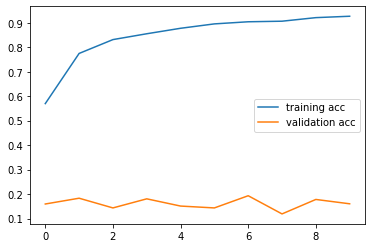

In [177]:
acc = r.history['accuracy']
val_acc = r.history['val_accuracy']
loss = r.history['loss']
val_loss = r.history['val_loss']
plt.plot(acc,label="training acc")
plt.plot(val_acc,label="validation acc")
plt.legend()

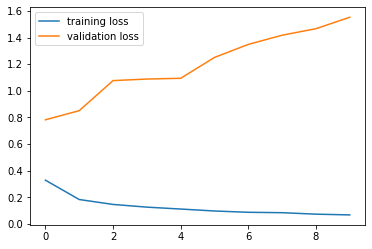

In [178]:
plt.plot(loss,label="training loss")
plt.plot(val_loss,label="validation loss")
plt.legend()

In [218]:
test_text = "Vladmir Putin"
test_seq = tokenizer.texts_to_sequences(test_text)
test_pad = pad_sequences(test_seq,maxlen=MAX_SEQUENCE_LENGTH)
subreddits=model.predict(test_pad)[0]

In [219]:
len(possible_labels)

6

In [223]:
for i in range(0,6):
    print(subreddits[i] ,possible_labels[i])

0.3211741 amitheasshole
0.36451364 todayilearned
0.48052305 explainlikeimfive
0.42789918 news
0.474048 askreddit
0.22632349 cornell
